In [17]:
import numpy as np
import pandas as pd

In [17]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import timm

In [18]:
def load_data(base_dir, img_height, img_width, batch_size):
    transform = transforms.Compose([
        transforms.Resize((img_height, img_width)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    dataset = datasets.ImageFolder(base_dir, transform=transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    return train_loader, val_loader

In [19]:
base_dir = 'C:\\final_project\\comprehensive_kidney_disease_classification\\artifacts\\data_ingestion\\kidney-ct-scan-image'
img_height, img_width = 224, 224
batch_size = 32
train_loader, val_loader = load_data(base_dir, img_height, img_width, batch_size)

def create_deit_model(num_classes, pretrained=True):
    model = timm.create_model('deit_base_patch16_224', pretrained=pretrained)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

In [20]:
num_classes = 4
model = create_deit_model(num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

device = torch.device("cpu")  # Use CPU
model = model.to(device)

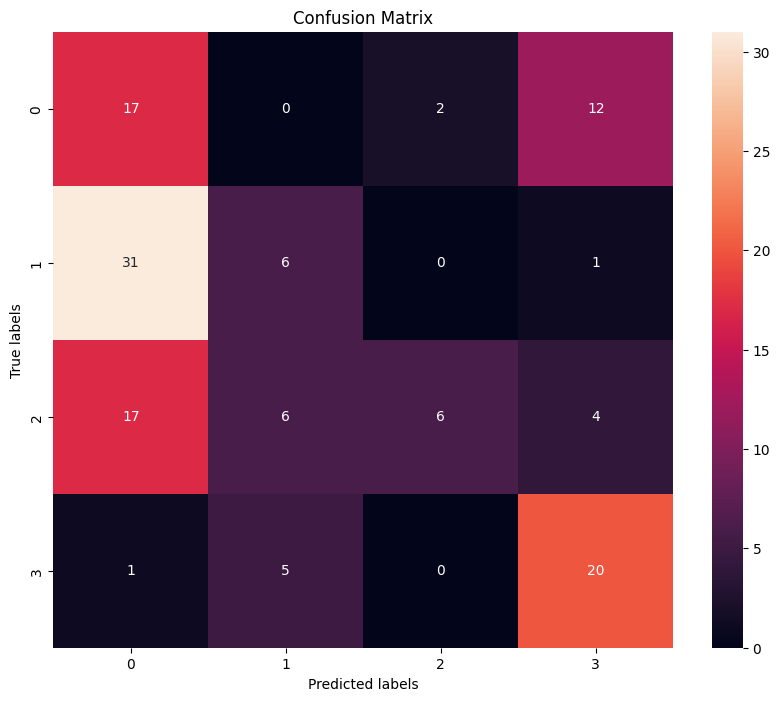

              precision    recall  f1-score   support

           0       0.26      0.55      0.35        31
           1       0.35      0.16      0.22        38
           2       0.75      0.18      0.29        33
           3       0.54      0.77      0.63        26

    accuracy                           0.38       128
   macro avg       0.48      0.41      0.37       128
weighted avg       0.47      0.38      0.35       128



In [21]:
def create_confusion_matrix_and_report(model, val_loader, device='cpu'):  # Ensure device is 'cpu'
    model.to(device)
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Confusion Matrix
    conf_matrix = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_matrix, annot=True, fmt='g')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.savefig('confusion_matrix.png')
    plt.show()

    # Classification Report
    class_report = classification_report(all_labels, all_preds, output_dict=True)
    print(classification_report(all_labels, all_preds))
    report_df = pd.DataFrame(class_report).transpose()
    report_df.to_csv('classification_report.csv')

# Train and evaluate the model
# model = train_and_evaluate(model, criterion, optimizer, train_loader, val_loader)
# Generate and save confusion matrix and classification report
create_confusion_matrix_and_report(model, val_loader)